<a href="https://colab.research.google.com/github/ralfcam/LANL-Earthquake-Prediction/blob/master/regionprops_V0_18_0rc0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIRA 2021

In [1]:
# pip install scikit-image==0.18.0rc0

In [2]:
# pip install pycaret

In [3]:
import skimage
skimage.__version__

'0.18.0rc0'

In [4]:
# from skimage import data, util
# from skimage.measure import label, regionprops
# import numpy as np
from scipy.stats import skew
# img = util.img_as_ubyte(data.coins()) > 110
# label_img = label(img, connectivity=img.ndim)

def sd_intensity(regionmask, intensity_image):
        return np.std(intensity_image[np.nonzero(regionmask)])

def skew_intensity(regionmask, intensity_image):
        return skew(intensity_image[np.nonzero(regionmask)])

def intensity_img(regionmask, intensity_image):
        return (intensity_image*regionmask).flatten()
    
# props = regionprops(label_img, intensity_image=data.coins(),
#                     extra_properties=(sd_intensity, mask_img))

In [5]:

# plt.imshow(props[-4].mask_img[0], cmap = "gray")

In [6]:
import pandas as pd
import numpy as np
import skimage.measure as measure
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage import io
# import cv2
from sklearn.mixture import GaussianMixture as GMM
from skimage.filters import threshold_otsu
from scipy import ndimage

/usr/local/lib/python3.6/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [7]:
from pycaret.clustering import *

In [8]:
image = r"Img_Low_Res27280_ORG.png"

In [9]:
def crop_center(img,cropx,cropy):
    y, x, z = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


In [10]:
im = Image.open(image)
hsv_arr = np.array(im.convert('HSV'))
rgb_arr = np.array(im)

side_x = int(rgb_arr.shape[0] * 0.85)
side_y = int(rgb_arr.shape[1] * 0.85)
# Here the image "im" is cropped and assigned to new variable im_crop
# im_crop = im.crop((left, upper, right, lower))
crop_rgb  = crop_center(rgb_arr, side_x, side_y)
crop_hsv  = crop_center(hsv_arr, side_x, side_y)

#extract blue channel
blue_channel = crop_rgb[:,:,2]
hsv_rgb_arr = np.concatenate((crop_hsv,
                              blue_channel.reshape(side_x, side_y, 1)), -1)  # 

#we need to to flat the image, like that trhe k means will not read it, in this case (with x lenght, 1)
image_features = hsv_rgb_arr.reshape(-1, hsv_rgb_arr.shape[-1])

In [11]:
image_features.shape

(14622976, 4)

In [12]:
# unique, counts = np.unique(blue_channel, return_counts=True)
# D = dict(zip(unique, counts))
# plt.bar(D.keys(), D.values() , 1, color='b')

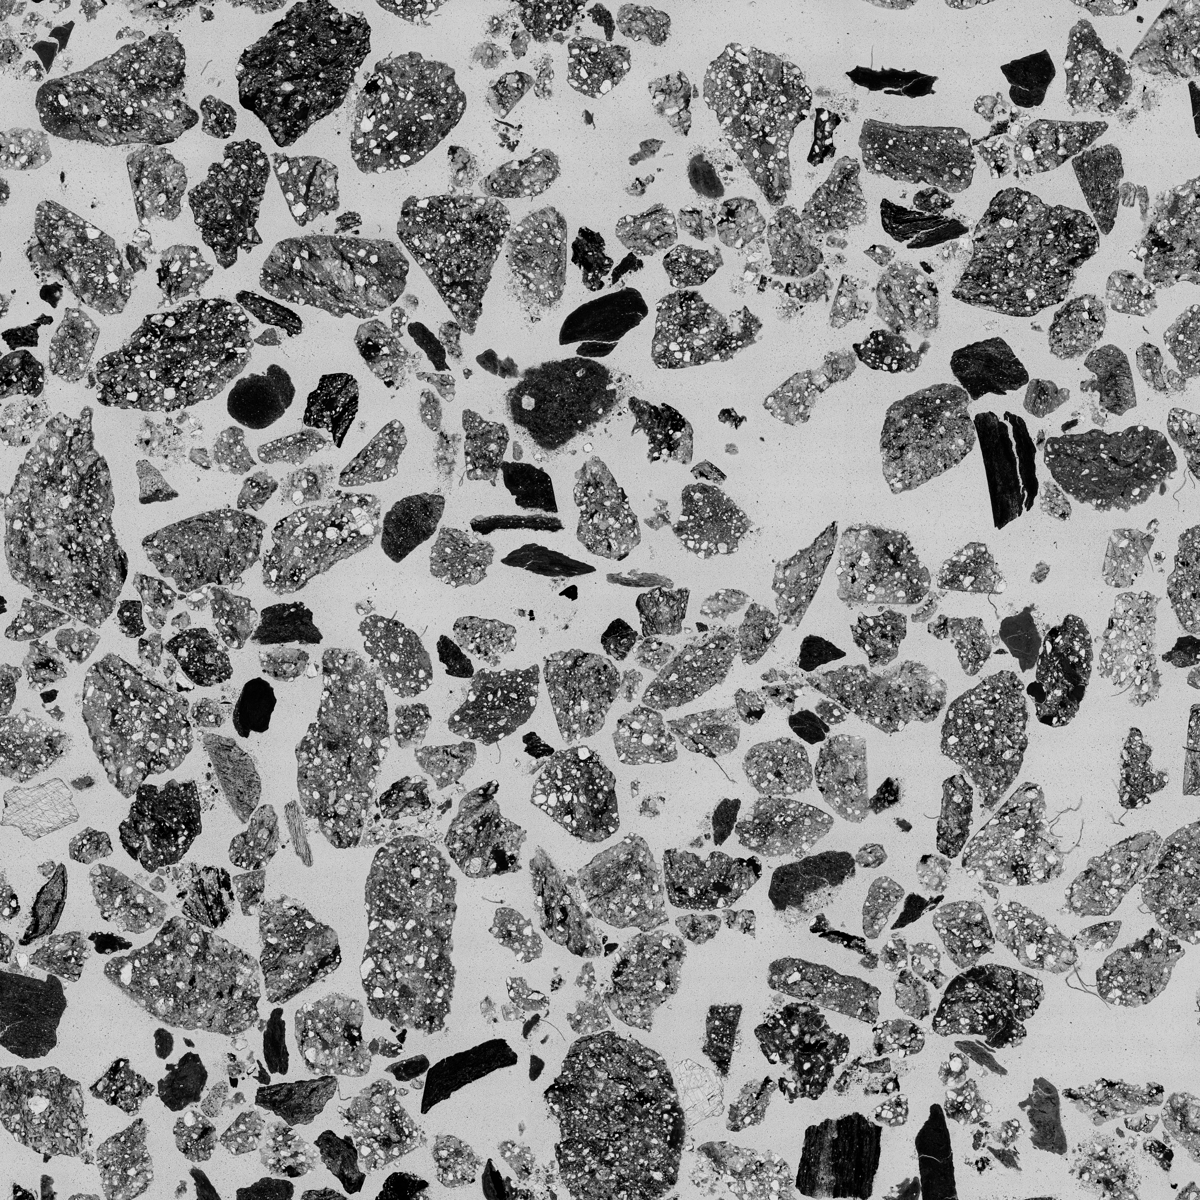

In [13]:
import IPython.display
IPython.display.display_png(Image.fromarray(blue_channel).resize((1200,1200)))

In [14]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import preprocessing

X_scaled = preprocessing.scale(image_features)
pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)

In [15]:
#creates GMM
NUM_COMPO = 2
#si coges covariaza esferica los clusters los coge como circulos
gmm = GMM(n_components=NUM_COMPO, 
          covariance_type = "tied").fit_predict(components)

#reconstruct the image into original shape 
categorized = gmm.reshape(side_x, side_y)

In [16]:
std_compo = [blue_channel[np.nonzero(categorized == i)].std() for i in range(NUM_COMPO)]
resin_cat = std_compo.index(max(std_compo))

mask_bin_cond = (categorized == resin_cat)
mask_bin_cond = mask_bin_cond.astype(bool)

In [17]:
labels = ndimage.label(mask_bin_cond)[0]

In [18]:
properties_text = {
    'Area': 'area',
    'Label': 'label',
    'Solidity': 'solidity',
}

props = measure.regionprops_table(label_image = labels,
                                  properties  = set(properties_text.values()),
                                  # extra_properties=(sd_intensity)
                                  )
data = pd.DataFrame(props)

properties_rgb = [
              'label',
              'max_intensity',
              'mean_intensity',
              'min_intensity',
              'intensity_image'
              ]

rgb_img_lst = [
               crop_hsv[:,:,0], crop_hsv[:,:,1], crop_hsv[:,:,2],
              #  crop_rgb[:,:,0], crop_rgb[:,:,1], 
               crop_rgb[:,:,2]
               ]
for i, image in enumerate(rgb_img_lst):
  props = measure.regionprops_table(label_image = labels, 
                                    intensity_image = image, 
                                    properties = properties_rgb,
                                    extra_properties=(skew_intensity, sd_intensity)
                                    )
  data_int = pd.DataFrame(props)
  data_int = data_int.rename(columns={"max_intensity":  f"max_intensity_{i}", 
                                      "mean_intensity": f"mean_intensity_{i}", 
                                      "min_intensity":  f"min_intensity_{i}",
                                      "sd_intensity":  f"sd_intensity_{i}",
                                      "skew_intensity":  f"skew_intensity_{i}",
                                      "intensity_image":  f"intensity_image_{i}"
                                      })
  print(i)
  # data = data.join(, left_on='Index')
  # data = pd.concat([data, data_int.set_index('label')], axis=0)
  data = data.merge(data_int, on='label')

0
1
2
3


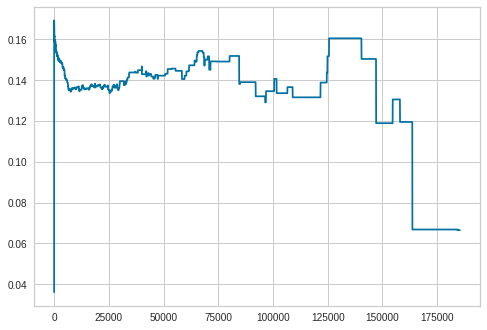

In [58]:
dataset = data.copy().set_index('label')
fin_ = int(dataset['area'].q())
sns.lineplot(x= range(1 , fin_, 10), y=[1 - dataset['solidity'][dataset['area'] >= i].mean() for i in range(1 , fin_, 10)])

In [83]:
dataset_train = dataset.copy()[dataset['area'] >= 10000]
dataset_train.describe()

solidity           area  ...  skew_intensity_3  sd_intensity_3
count  174.000000     174.000000  ...        174.000000      174.000000
mean     0.863751   40794.798851  ...          0.470343       49.798798
std      0.079026   36240.174422  ...          0.861097       10.121345
min      0.587081   10010.000000  ...         -1.996557       17.333332
25%      0.820573   17420.750000  ...          0.008905       47.744822
50%      0.883633   27305.000000  ...          0.252061       52.031391
75%      0.926926   49850.250000  ...          0.626365       55.898777
max      0.975098  185415.000000  ...          3.868094       68.505992

[8 rows x 22 columns]

In [84]:
exclude = ['area', 'solidity'] + [img for img in dataset_train if 'image' in img]
no_paja = setup(dataset_train,
          transformation = True, 
          ignore_features=exclude,  # 'solidity'
          silent=True,
          verbose=False,
          use_gpu=True)

In [85]:
model = create_model(['kmeans', 'ap', 
                      'meanshift', 'sc',
                      'hclust', 'dbscan',
                      'optics', 'birch',
                      'kmodes'][0])

Silhouette  Calinski-Harabasz  ...  Rand Index  Completeness
0      0.2866            86.2757  ...           0             0

[1 rows x 6 columns]

In [86]:
# models()

In [87]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Cluster PCA Plot (2d)', …

In [88]:
predictions = assign_model(model)

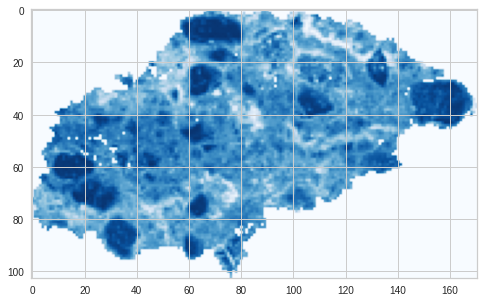

In [106]:
CLUST_N = 'Cluster 0'
SAMPLES = 1
int_im = predictions[predictions['Cluster'] == CLUST_N]['intensity_image_3'].sample(SAMPLES)
plt.imshow(int_im.values[0], cmap='Blues')

# [plt.imshow(int_im.values[sample]) for sample in range(SAMPLES)]

In [90]:
predictions["cluster_cat_codes"] = predictions["Cluster"].astype('category').cat.codes + 1
map_d = predictions['cluster_cat_codes'].to_dict()
vfunc = np.vectorize(lambda x: map_d[x] if x in map_d.keys() else 0)
clust_on_img = vfunc(labels)

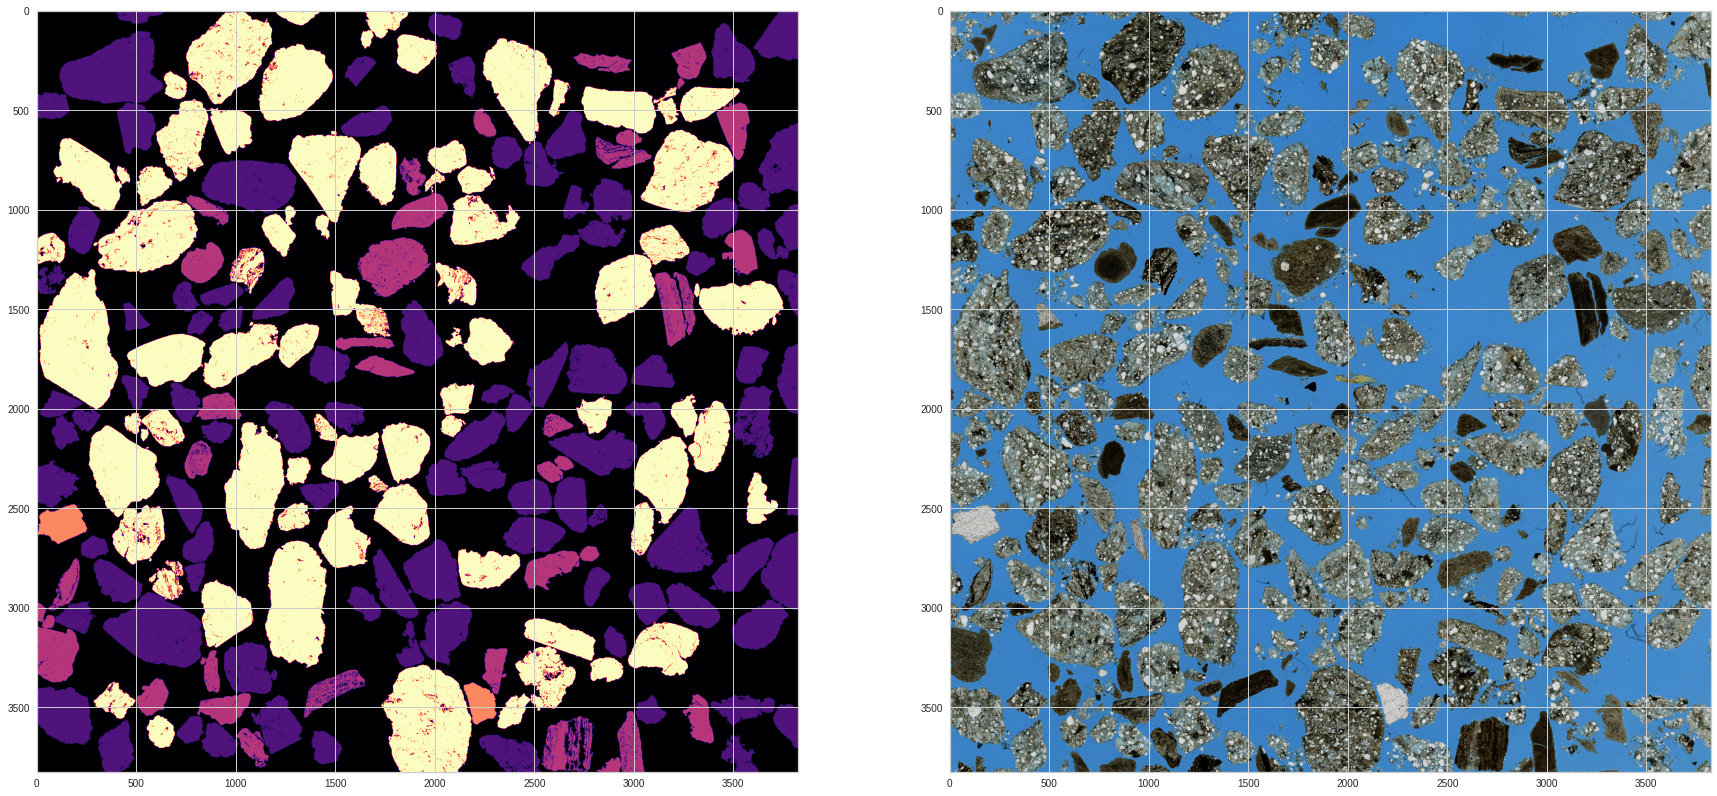

In [91]:
img_lst = [clust_on_img, crop_rgb]
fig=plt.figure(figsize=(30, 30))
plt.rcParams['axes.titlesize'] = 20
columns = 2
rows = 1
for i, img in zip(range(1, columns*rows +1), img_lst):
    img = img
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="magma")
plt.show()

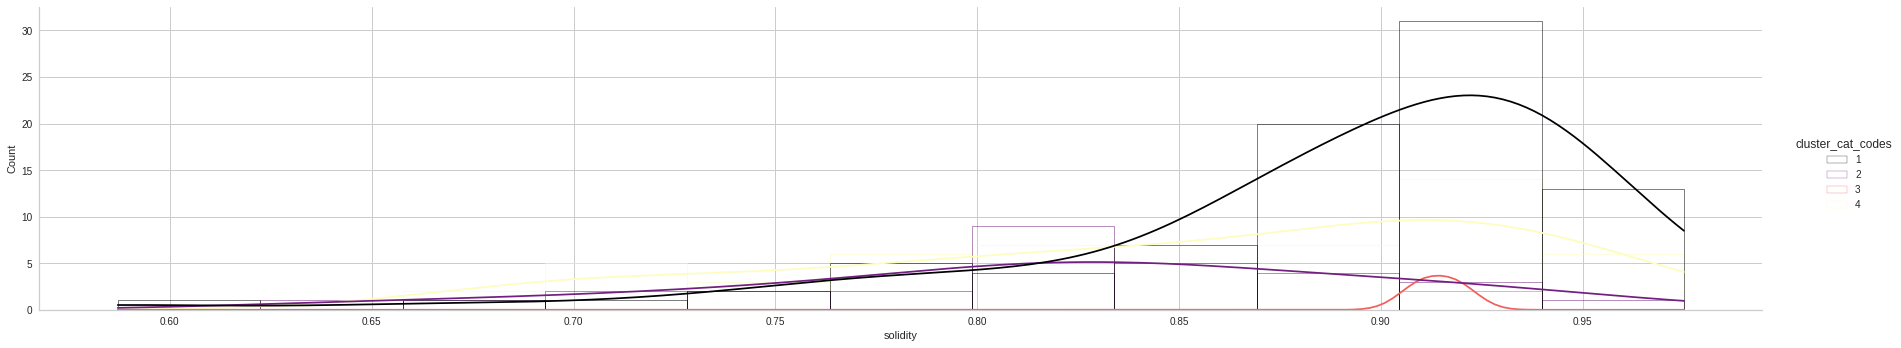

In [92]:
sns.displot(predictions, x="solidity", hue="cluster_cat_codes",
            kde=True, fill=False, height=5, aspect=5, palette='magma')

### UNSTABLE

In [ ]:
# for_concat = final_image.reshape(side, side, 1)
# d3_labels = np.concatenate((for_concat, for_concat, for_concat), -1)
# properties = [
#               'label', 
#               # 'area',
#               # 'bbox',
#               # 'bbox_area',
#               # 'moments_central',
#               # 'centroid',
#               # 'convex_area',
#               # 'ConvexHull', not availabel in this version
#               # 'convex_image',
#               # 'coords',
#               # 'eccentricity',
#               'equivalent_diameter',
#               # 'euler_number',
#               # 'extent',
#               # 'Extrema',  not availabel in this version
#               # 'feret_diameter_max', not availabel in this version
#               # 'filled_area',
#               # 'filled_image',
#               # 'moments_hu',
#               # 'image',
#               # 'inertia_tensor',
#               # "inertia_tensor_eigvals",
#               # 'intensity_image',
#               # 'local_centroid',
#               # 'major_axis_length',
#               'max_intensity',
#               'mean_intensity',
#               'min_intensity',
#               # 'minor_axis_length',
#               # 'moments',
#               # 'moments_normalized',
#               # 'orientation',
#               # 'perimeter',
#               # 'perimeter_crofton', not availabel in this version
#               # 'PixelIdxList', not availabel in this version
#               # 'PixelList', not availabel in this version
#               # 'slice',
#               'solidity',
#               # 'SubarrayIdx', not availabel in this version
#               # 'weighted_moments_central',
#               # 'weighted_centroid',
#               # 'weighted_moments_hu',
#               # 'weighted_local_centroid',
#               # 'weighted_moments',
#               # 'weighted_moments_normalized'
#               ]


# # data_todos = pd.DataFrame()
# props = measure.regionprops_table(label_image = d3_labels,
#                                   intensity_image = crop_rgb,
#                                   properties= properties)

# data = pd.DataFrame(props)
# # sample = re.findall( "[a-z]\w*", str(image))
# data["sample"] = sample[0]